In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.autograd import Variable

import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline

#### Load MNIST Dataset

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = MNIST('/data', train=True, download=True, transform=transform)
test_dataset = MNIST('/data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=True)

In [3]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

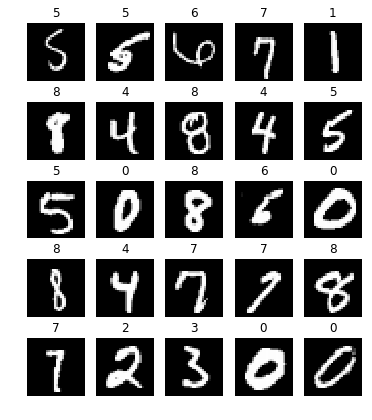

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

#### Function to plot deep features at given epoch

In [5]:
def plot(conv_out, train_marks, test_marks, epoch=20):
    last_conv_out = conv_out[(epoch-1) * 70000:epoch * 70000]
    plt.figure(figsize=(16, 7))

    colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
    plt.subplot(1, 2, 1)
    for label in range(10):
        plt.scatter(last_conv_out[:60000, 0][np.array(train_marks[epoch-1]) == label],
                    last_conv_out[:60000, 1][np.array(train_marks[epoch-1]) == label],
                    s=1, c=colors[label])

    lgnd = plt.legend(['0', '1', '2', '3', '4', '5', '6',
                       '7', '8', '9'], loc="lower right")
    for idx in range(10):
        lgnd.legendHandles[idx]._sizes = [30]
    plt.xlabel('Activation of the 1st neuron', fontsize=12)
    plt.ylabel('Activation of the 2nd neuron', fontsize=12)
    plt.grid('on')

    plt.subplot(1, 2, 2)
    for label in range(10):
        plt.scatter(last_conv_out[-10000:, 0][np.array(test_marks[epoch-1]) == label],
                    last_conv_out[-10000:, 1][np.array(test_marks[epoch-1]) == label],
                    s=1, c=colors[label])

    lgnd = plt.legend(['0', '1', '2', '3', '4', '5', '6',
                       '7', '8', '9'], loc="lower right")
    for idx in range(10):
        lgnd.legendHandles[idx]._sizes = [30]
    plt.xlabel('Activation of the 1st neuron', fontsize=12)
    plt.ylabel('Activation of the 2nd neuron', fontsize=12)
    plt.grid('on')
    plt.show()

#### LeNet++ architecture

In [6]:
class LeNet_plus(nn.Module):
    def __init__(self):
        super(LeNet_plus, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, stride=1, padding=2)
        self.act1 = nn.PReLU()
        self.conv2 = nn.Conv2d(32, 32, 5, stride=1, padding=2)
        self.act2 = nn.PReLU()
        self.pool1 = nn.MaxPool2d(2, stride=2, padding=0)

        self.conv3 = nn.Conv2d(32, 64, 5, stride=1, padding=2)
        self.act3 = nn.PReLU()
        self.conv4 = nn.Conv2d(64, 64, 5, stride=1, padding=2)
        self.act4 = nn.PReLU()
        self.pool2 = nn.MaxPool2d(2, stride=2, padding=0)

        self.conv5 = nn.Conv2d(64, 128, 5, stride=1, padding=2)
        self.act5 = nn.PReLU()
        self.conv6 = nn.Conv2d(128, 128, 5, stride=1, padding=2)
        self.act6 = nn.PReLU()
        self.pool3 = nn.MaxPool2d(2, stride=2, padding=0)

        self.fc1 = nn.Linear(3*3*128, 2)
        self.act7 = nn.PReLU()
        self.fc2 = nn.Linear(2, 10)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.pool1(x)

        x = self.act3(self.conv3(x))
        x = self.act4(self.conv4(x))
        x = self.pool2(x)

        x = self.act5(self.conv5(x))
        x = self.act6(self.conv6(x))
        x = self.pool3(x)

        x = x.view(x.size(0), -1)

        # save features last FC layer
        feat = self.act7(self.fc1(x))
        x = F.log_softmax(self.fc2(feat))

        return feat, x

#### CenterLoos class for centroids updated by autograd

In [7]:
class CenterLoss_with_autograd(nn.Module):
    def __init__(self, num_classes, dim_feat):
        super(CenterLoss_with_autograd, self).__init__()
        self.num_classes = num_classes
        self.dim_feat = dim_feat
        self.centers = nn.Parameter(torch.randn(num_classes, dim_feat))

    def forward(self, y, deep_feat):
        batch_size = deep_feat.size(0)
        chosen_centers = self.centers.index_select(dim=0, index=y)

        # 2-norm
        p_norm = deep_feat.dist(chosen_centers, p=2)
        loss = 1.0 / 2 * p_norm / batch_size
        return loss
    
    def backward(self, y, deep_feat):
        chosen_centers = self.centers.index_select(dim=0, index=y)
        return outputs.cpu() - indexing_centers

#### CenterLoss with manually updated centroids 

In [8]:
class CenterLoss_with_delta(nn.Module):
    def __init__(self, num_classes, dim_feat):
        super(CenterLoss_with_delta, self).__init__()
        self.num_classes = num_classes
        self.dim_feat = dim_feat
        self.centers = nn.Parameter(torch.randn(num_classes, dim_feat))

    def forward(self, y, deep_feat):

        # Get loss
        batch_size = deep_feat.size(0)
        chosen_centers = self.centers.index_select(0, y.long())

        # Eq. 2
        p_norm = deep_feat.dist(chosen_centers, p=2)
        loss = 1.0 / 2 * p_norm / batch_size

        # Update centroids
        new_centers = torch.Tensor().cuda()
        # for each mark get new batch cantroide
        for i in range(self.num_classes):
            if i in y.data:
                # marks idx for current class
                idx_true = (y.data == i).nonzero().view(-1)

                # new centroid
                tmp = (deep_feat.index_select(0, idx_true)).mean(0).view(1, -1)
                new_centers = torch.cat((new_centers, tmp), 0)
            else:
                # zeros if no mark in batch
                new_centers = torch.cat(
                    (new_centers, torch.randn(1, self.dim_feat).cuda()), 0)

        # class buckets for batch
        hist = torch.histc(y.cpu().data.float(), bins=self.num_classes, min=0, max=self.num_classes).cuda()

        # Eq. 4
        coeff = (hist / (1 + hist)).view(-1, 1)
        centers_grad = coeff * (self.centers - new_centers)

        return loss, centers_grad
    
    def backward(self, y, deep_feat):
        chosen_centers = self.centers.index_select(dim=0, index=y)
        return outputs.cpu() - indexing_centers

#### Train and test fuction

In [9]:
def train(network, device, center_loss, optimizer, center_optimizer, epochs, lambda_, use_delta):
    global test_marks, train_marks

    nll_loss = nn.NLLLoss()

    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []

    try:
        for epoch in range(1, epochs+1):
            losses = []
            accuracies = []
            batch_marks = []

            network.train()
            for batch_idx, (X, y) in enumerate(train_loader):
                batch_marks.extend(y.numpy())
                X, y = X.to(device), y.to(device)
                network.zero_grad()
                center_loss.zero_grad()

                deep_feat, prediction = network(X)
                if use_delta:
                    # manually computed centroids
                    loss_center, grad = center_loss(y, deep_feat)
                    loss_batch = nll_loss(prediction, y) + \
                        lambda_ * loss_center

                    losses.append(loss_batch.data[0])

                    loss_batch.backward()

                    center_loss.zero_grad()
                    center_loss.centers.backward(grad)

                    optimizer.step()

                else:
                    # autograd
                    loss_batch = nll_loss(prediction, y) + \
                        lambda_ * center_loss(y, deep_feat)

                    losses.append(loss_batch.data[0])

                    loss_batch.backward()

                    optimizer.step()
                    center_optimizer.step()

                accuracies.append(
                    (np.argmax(prediction.cpu().data.numpy(), 1) == y.cpu().data.numpy()).mean())

                if batch_idx % 10 == 0:
                    sys.stdout.write('\rTrain Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, epochs, 
                        batch_idx * len(X), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), losses[-1]))

            train_marks.append(batch_marks)
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))

            losses = []
            accuracies = []
            batch_marks = []

            network.eval()
            for X, y in test_loader:
                batch_marks.extend(y.numpy())
                X, y = X.to(device), y.to(device)
                deep_feat, prediction = network(X)

                if use_delta:
                    loss_center, params_grad = center_loss(y, deep_feat)
                    loss_batch = nll_loss(prediction, y) + \
                        lambda_ * loss_center
                else:
                    loss_batch = nll_loss(prediction, y) + \
                        lambda_ * center_loss(y, deep_feat)

                losses.append(loss_batch.data[0])
                accuracies.append(
                    (np.argmax(prediction.cpu().data.numpy(), 1) == y.cpu().data.numpy()).mean())

            test_marks.append(batch_marks)
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            print('\nEpoch {0}. (Train/Test) Average loss: {1:.4f}/{2:.4f}\tAccuracy: {3:.4f}/{4:.4f}\n'.format(
                epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            
    except KeyboardInterrupt:
        pass

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.ylim(0.9, 1.0)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

#### Function for hook to get deep features 

In [10]:
def get_out(self, input, output):
    global conv_out
    conv_out = np.concatenate((conv_out, output.cpu().data.numpy()), axis=0)

#### Network init  and run

In [11]:
def init_net_and_train(epochs=20, lambda_=0, use_delta=0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    network = LeNet_plus().to(device)
    optimizer = optim.Adam(network.parameters(), lr=1e-4)

    if use_delta:
        centerloss = CenterLoss_with_delta(10, 2).to(device)
        center_optimizer = None
    else:
        centerloss = CenterLoss_with_autograd(10, 2).to(device)
        center_optimizer = optim.SGD(centerloss.parameters(), lr=0.5)

    network.fc1.register_forward_hook(get_out)

    train(network, device, centerloss, optimizer,
          center_optimizer, epochs, lambda_, use_delta)

#### Training with NLLLoss only

In [12]:
epochs = 20

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train Epoch: 1/20 [59520/60000 (99%)]	Loss: 0.830755

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Epoch 1. (Train/Test) Average loss: 1.2970/0.9576	Accuracy: 0.4412/0.5574

Train Epoch: 2/20 [59520/60000 (99%)]	Loss: 0.523347
Epoch 2. (Train/Test) Average loss: 0.8157/0.6312	Accuracy: 0.6667/0.7571

Train Epoch: 3/20 [59520/60000 (99%)]	Loss: 0.529906
Epoch 3. (Train/Test) Average loss: 0.5001/0.3569	Accuracy: 0.8475/0.9107

Train Epoch: 4/20 [59520/60000 (99%)]	Loss: 0.269197
Epoch 4. (Train/Test) Average loss: 0.3430/0.2698	Accuracy: 0.9215/0.9425

Train Epoch: 5/20 [59520/60000 (99%)]	Loss: 0.172073
Epoch 5. (Train/Test) Average loss: 0.2629/0.2288	Accuracy: 0.9470/0.9563

Train Epoch: 6/20 [59520/60000 (99%)]	Loss: 0.135536
Epoch 6. (Train/Test) Average loss: 0.2103/0.1781	Accuracy: 0.9568/0.9636

Train Epoch: 7/20 [59520/60000 (99%)]	Loss: 0.131672
Epoch 7. (Train/Test) Average loss: 0.1623/0.1519	Accuracy: 0.9644/0.9665

Train Epoch: 8/20 [59520/60000 (99%)]	Loss: 0.034013
Epoch 8. (Train/Test) Average loss: 0.1282/0.1942	Accuracy: 0.9697/0.9573

Train Epoch: 9/20 [59520/600

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


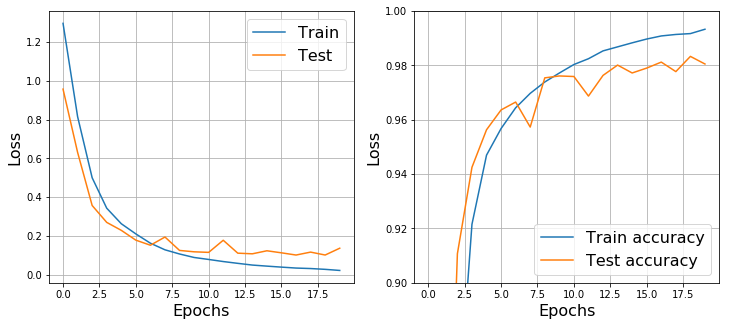

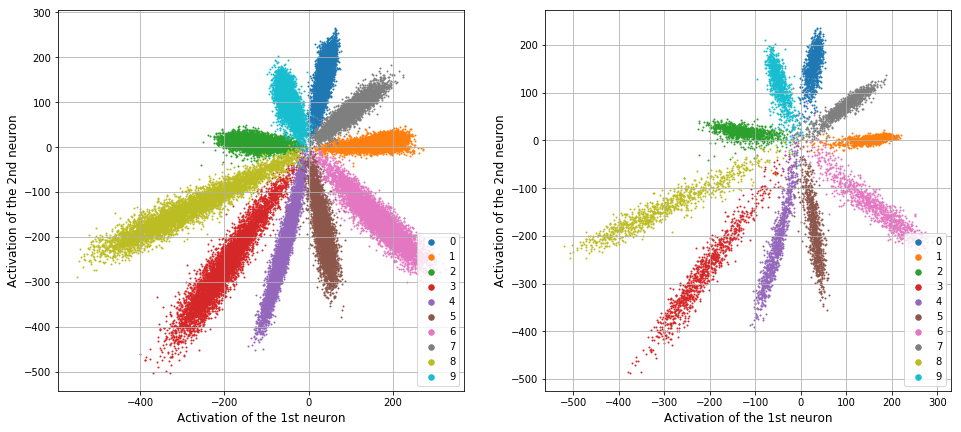

In [13]:
# three arrays to plot data
conv_out = np.empty([0,2])
test_marks = []
train_marks = []

init_net_and_train(epochs)
plot(conv_out, train_marks, test_marks, epochs)

#### Training with NLLLoss and SGD centroids with lambda 0.1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train Epoch: 1/20 [59520/60000 (99%)]	Loss: 1.185359

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Epoch 1. (Train/Test) Average loss: 1.3351/0.9347	Accuracy: 0.4641/0.6122

Train Epoch: 2/20 [59520/60000 (99%)]	Loss: 0.629051
Epoch 2. (Train/Test) Average loss: 0.8166/0.5294	Accuracy: 0.7230/0.7861

Train Epoch: 3/20 [59520/60000 (99%)]	Loss: 0.483030
Epoch 3. (Train/Test) Average loss: 0.5878/0.3845	Accuracy: 0.8536/0.9315

Train Epoch: 4/20 [59520/60000 (99%)]	Loss: 0.380471
Epoch 4. (Train/Test) Average loss: 0.4742/0.3166	Accuracy: 0.9071/0.9519

Train Epoch: 5/20 [59520/60000 (99%)]	Loss: 0.341417
Epoch 5. (Train/Test) Average loss: 0.3993/0.2287	Accuracy: 0.9631/0.9748

Train Epoch: 6/20 [59520/60000 (99%)]	Loss: 0.350129
Epoch 6. (Train/Test) Average loss: 0.3359/0.2059	Accuracy: 0.9765/0.9784

Train Epoch: 7/20 [59520/60000 (99%)]	Loss: 0.291663
Epoch 7. (Train/Test) Average loss: 0.3040/0.1680	Accuracy: 0.9809/0.9821

Train Epoch: 8/20 [59520/60000 (99%)]	Loss: 0.243123
Epoch 8. (Train/Test) Average loss: 0.2798/0.1609	Accuracy: 0.9849/0.9837

Train Epoch: 9/20 [59520/600

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


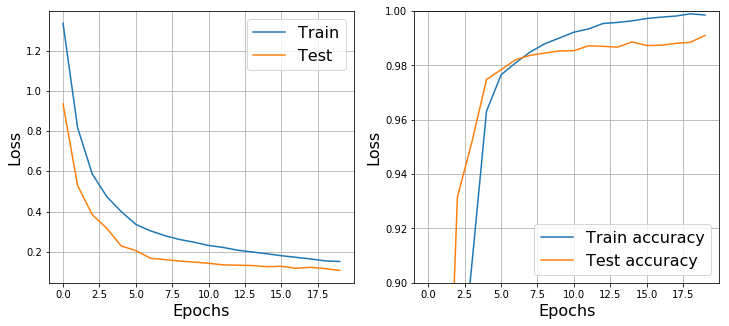

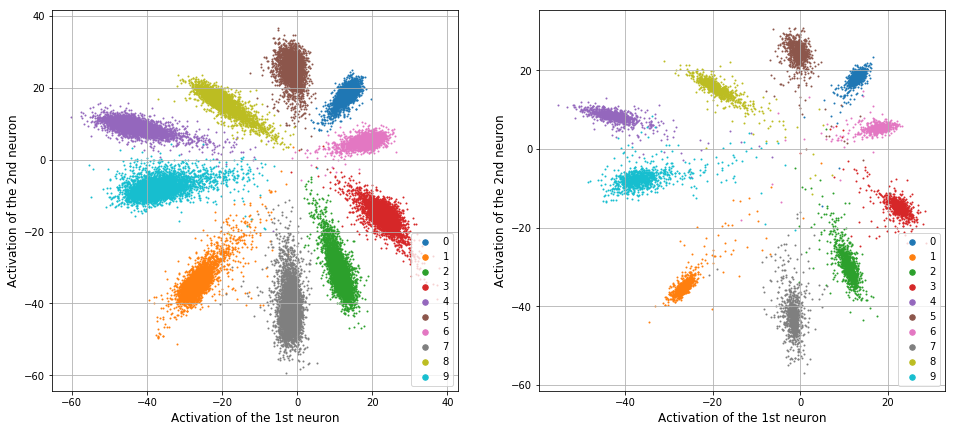

In [14]:
conv_out = np.empty([0,2])
test_marks = []
train_marks = []

init_net_and_train(epochs, lambda_=0.1, use_delta=0)
plot(conv_out, train_marks, test_marks, epochs)

#### Training with NLLLoss and delta centroids  with lambda 0.1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train Epoch: 1/20 [59520/60000 (99%)]	Loss: 1.011892

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Epoch 1. (Train/Test) Average loss: 1.4137/0.9376	Accuracy: 0.4582/0.7368

Train Epoch: 2/20 [59520/60000 (99%)]	Loss: 0.727276
Epoch 2. (Train/Test) Average loss: 0.8552/0.6079	Accuracy: 0.7901/0.8308

Train Epoch: 3/20 [59520/60000 (99%)]	Loss: 0.387535
Epoch 3. (Train/Test) Average loss: 0.6141/0.3674	Accuracy: 0.8825/0.9570

Train Epoch: 4/20 [59520/60000 (99%)]	Loss: 0.455056
Epoch 4. (Train/Test) Average loss: 0.4680/0.3079	Accuracy: 0.9642/0.9680

Train Epoch: 5/20 [59520/60000 (99%)]	Loss: 0.320133
Epoch 5. (Train/Test) Average loss: 0.4158/0.2619	Accuracy: 0.9731/0.9748

Train Epoch: 6/20 [59520/60000 (99%)]	Loss: 0.360410
Epoch 6. (Train/Test) Average loss: 0.3813/0.2443	Accuracy: 0.9786/0.9768

Train Epoch: 7/20 [59520/60000 (99%)]	Loss: 0.345783
Epoch 7. (Train/Test) Average loss: 0.3516/0.2295	Accuracy: 0.9825/0.9798

Train Epoch: 8/20 [59520/60000 (99%)]	Loss: 0.276556
Epoch 8. (Train/Test) Average loss: 0.3283/0.2081	Accuracy: 0.9855/0.9807

Train Epoch: 9/20 [59520/600

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


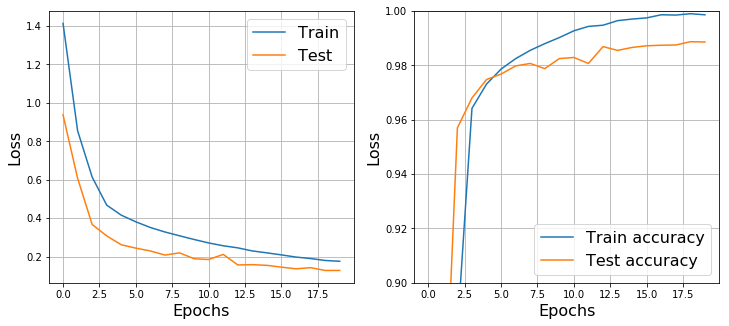

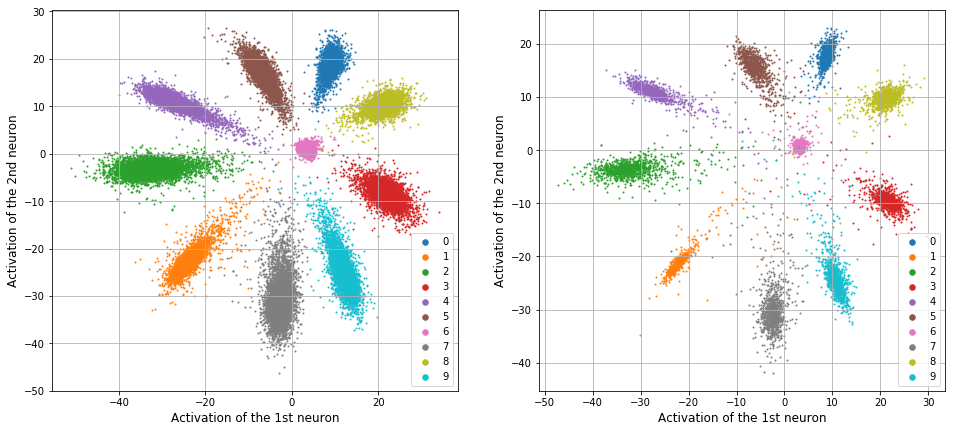

In [15]:
conv_out = np.empty([0,2])
test_marks = []
train_marks = []

init_net_and_train(epochs, lambda_=0.1, use_delta=1)
plot(conv_out, train_marks, test_marks, epochs)

#### Training with NLLLoss and SGD centroids with lambda 1.0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train Epoch: 1/20 [59520/60000 (99%)]	Loss: 1.184298

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Epoch 1. (Train/Test) Average loss: 1.5549/1.0526	Accuracy: 0.5238/0.6350

Train Epoch: 2/20 [59520/60000 (99%)]	Loss: 1.101723
Epoch 2. (Train/Test) Average loss: 1.1007/0.8244	Accuracy: 0.6816/0.7270

Train Epoch: 3/20 [59520/60000 (99%)]	Loss: 0.733737
Epoch 3. (Train/Test) Average loss: 0.8725/0.6713	Accuracy: 0.7695/0.8490

Train Epoch: 4/20 [59520/60000 (99%)]	Loss: 0.590232
Epoch 4. (Train/Test) Average loss: 0.7169/0.5901	Accuracy: 0.9027/0.9497

Train Epoch: 5/20 [59520/60000 (99%)]	Loss: 0.711151
Epoch 5. (Train/Test) Average loss: 0.6068/0.4973	Accuracy: 0.9638/0.9710

Train Epoch: 6/20 [59520/60000 (99%)]	Loss: 0.424886
Epoch 6. (Train/Test) Average loss: 0.5215/0.4256	Accuracy: 0.9785/0.9770

Train Epoch: 7/20 [59520/60000 (99%)]	Loss: 0.448306
Epoch 7. (Train/Test) Average loss: 0.4525/0.3672	Accuracy: 0.9837/0.9789

Train Epoch: 8/20 [59520/60000 (99%)]	Loss: 0.421961
Epoch 8. (Train/Test) Average loss: 0.3981/0.3191	Accuracy: 0.9867/0.9821

Train Epoch: 9/20 [59520/600

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


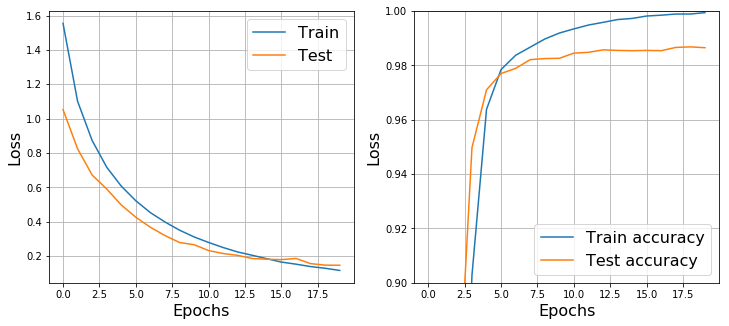

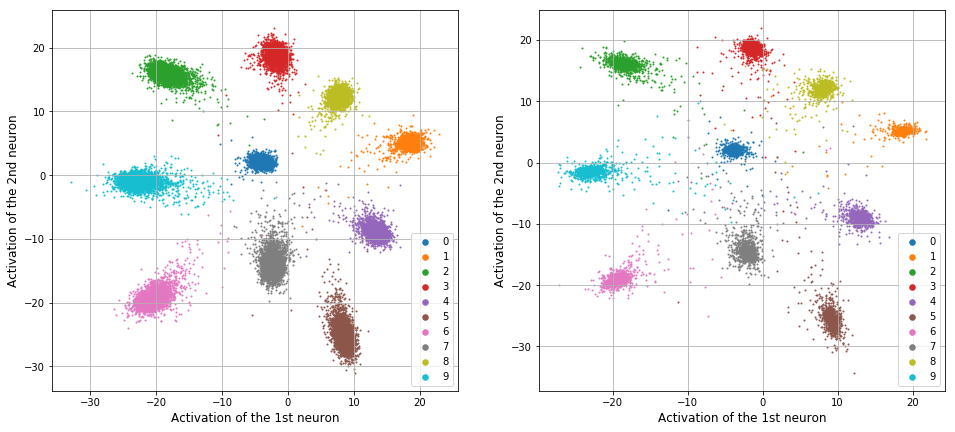

In [16]:
conv_out = np.empty([0,2])
test_marks = []
train_marks = []

init_net_and_train(epochs, lambda_=1.0, use_delta=0)
plot(conv_out, train_marks, test_marks, epochs)

#### Training with NLLLoss and delta centroids with lambda 1.0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train Epoch: 1/20 [59520/60000 (99%)]	Loss: 1.534822

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Epoch 1. (Train/Test) Average loss: 1.6558/1.2950	Accuracy: 0.3937/0.4131

Train Epoch: 2/20 [59520/60000 (99%)]	Loss: 1.355296
Epoch 2. (Train/Test) Average loss: 1.4159/1.1045	Accuracy: 0.4719/0.5790

Train Epoch: 3/20 [59520/60000 (99%)]	Loss: 1.375009
Epoch 3. (Train/Test) Average loss: 1.2628/0.9056	Accuracy: 0.6817/0.7592

Train Epoch: 4/20 [59520/60000 (99%)]	Loss: 1.098036
Epoch 4. (Train/Test) Average loss: 1.1497/0.7841	Accuracy: 0.7927/0.8049

Train Epoch: 5/20 [59520/60000 (99%)]	Loss: 1.021291
Epoch 5. (Train/Test) Average loss: 1.0764/0.7145	Accuracy: 0.8471/0.8747

Train Epoch: 6/20 [59520/60000 (99%)]	Loss: 1.020014
Epoch 6. (Train/Test) Average loss: 1.0191/0.6504	Accuracy: 0.9009/0.8987

Train Epoch: 7/20 [59520/60000 (99%)]	Loss: 0.967179
Epoch 7. (Train/Test) Average loss: 0.9706/0.6180	Accuracy: 0.9491/0.9727

Train Epoch: 8/20 [59520/60000 (99%)]	Loss: 0.890210
Epoch 8. (Train/Test) Average loss: 0.9254/0.5849	Accuracy: 0.9796/0.9829

Train Epoch: 9/20 [59520/600

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


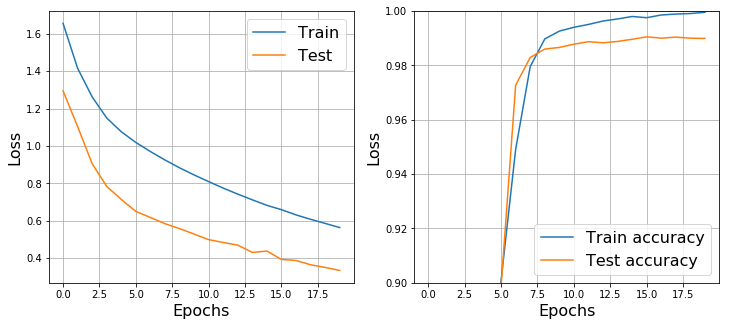

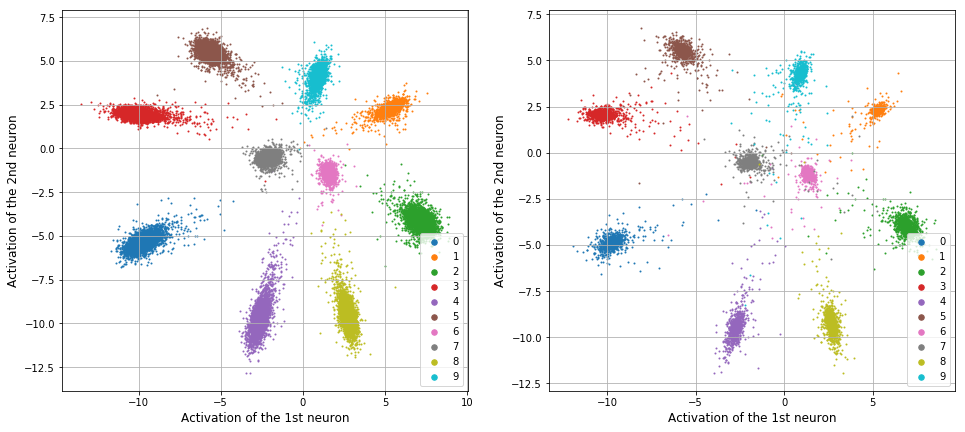

In [17]:
conv_out = np.empty([0,2])
test_marks = []
train_marks = []

init_net_and_train(epochs, lambda_=1.0, use_delta=1)
plot(conv_out, train_marks, test_marks, epochs)

#### Conclusion:
* SGD optimization is similar to delta update from paper
* Cluster position depends on data split and shuffle
* Results with NLLLoss can be trained with center loss